In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
from collections import Counter, defaultdict
from wordcloud import WordCloud
from mycolorpy import colorlist as mcp
import math
FONTSIZE=20
SYS_PATH = '/u/ajagadish/ermi' #'/raven/u/ajagadish/vanilla-llama/'

## model simulations on Lucas 2015 priors

/mpcdf/soft/RHEL_9/packages/x86_64/anaconda/3/2023.03/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:0'` for same effect.
  warnings.warn(msg, FutureWarning)


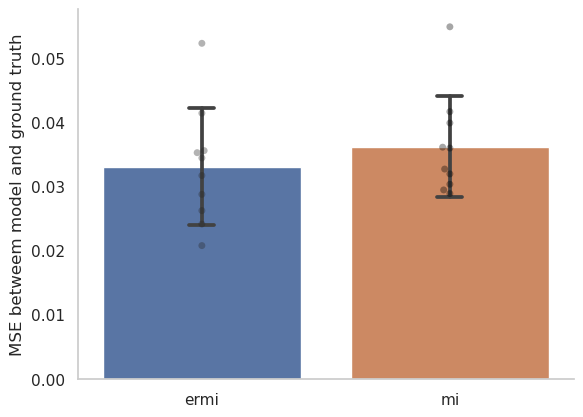

In [7]:
sns.set(style="whitegrid")
policy='greedy'
results_mi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic_syntheticfunctionlearning.npz')
results_ermi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/env=claude_dim1_maxsteps25_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_syntheticfunctionlearning.npz')
num_tasks = results_ermi['model_errors'].shape[1]
df = pd.DataFrame.from_dict({'ermi':results_ermi['model_errors'].mean(1).squeeze(),
                             'mi':results_mi['model_errors'].mean(1).squeeze(),
                            })
sns.barplot(data=df, capsize=.1, errorbar="sd")
sns.swarmplot(data=df, color="0", alpha=.35)
sns.despine()
plt.ylabel('MSE betweem model and ground truth')
plt.grid(visible=False)
plt.show() 

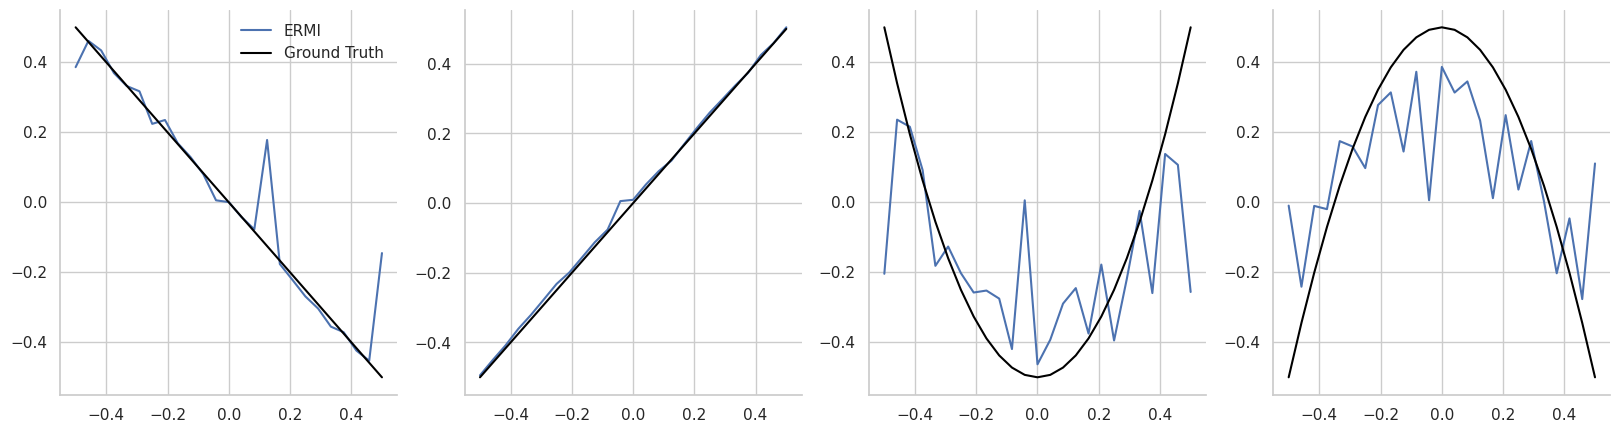

In [28]:
subject = 1
functions = np.unique(results_ermi['ground_truth_functions'])
num_participants = results_ermi['model_preds'].shape[0]
counter = 0
fig, axs = plt.subplots(1, len(functions), figsize=(5 * len(functions), 5))

for ix, function in enumerate(functions):
    find_functions = np.where(results_ermi['ground_truth_functions'][subject] == function)
    if len(find_functions[0]) > 0:
        function_idx = find_functions[0][0]
        
        # Extract and sort ERMI predictions
        ermi_human_preds = results_ermi['human_preds'][subject, function_idx]
        ermi_model_preds = results_ermi['model_preds'].squeeze()[subject, function_idx]
        sorted_indices_ermi = np.argsort(ermi_human_preds)
        ermi_human_preds_sorted = ermi_human_preds[sorted_indices_ermi]
        ermi_model_preds_sorted = ermi_model_preds[sorted_indices_ermi]
         
        # Plot the sorted values
        axs[ix].plot(ermi_human_preds_sorted, ermi_model_preds_sorted, label='ERMI')
        axs[ix].plot(ermi_human_preds_sorted, results_ermi['targets'][subject, function_idx][sorted_indices_ermi], c='black', label="Ground Truth")
        
        if counter == 0:
            axs[ix].legend(frameon=False)
            counter += 1

sns.despine()
plt.show()

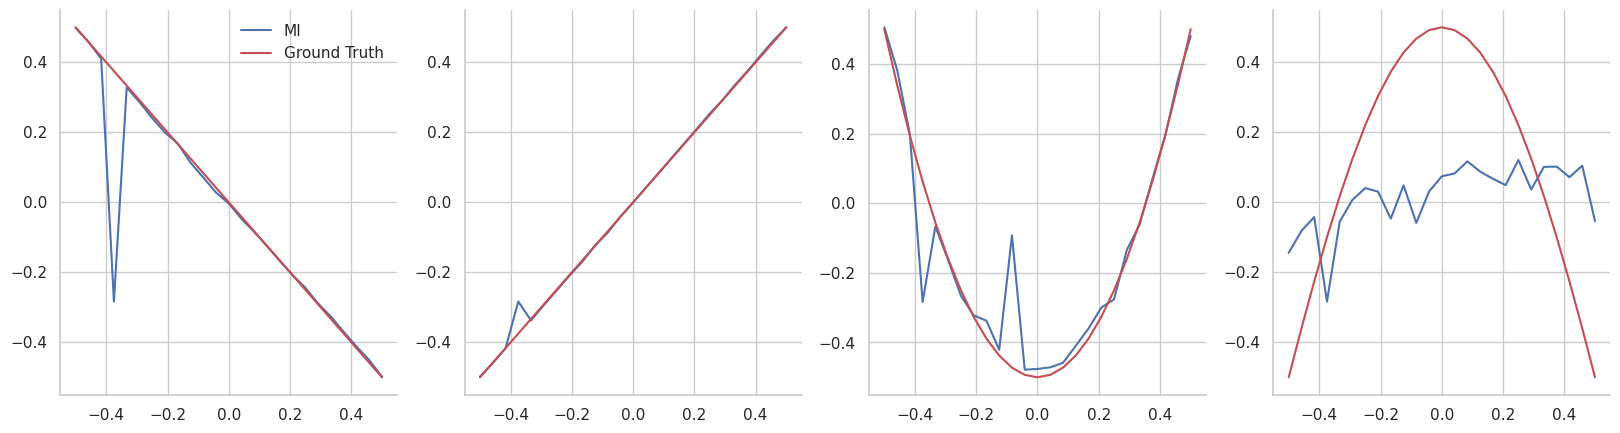

In [33]:
subject = 1
functions = np.unique(results_mi['ground_truth_functions'])
num_participants = results_mi['model_preds'].shape[0]
counter = 0
fig, axs = plt.subplots(1, len(functions), figsize=(5 * len(functions), 5))

for ix, function in enumerate(functions):
    find_functions = np.where(results_mi['ground_truth_functions'][subject] == function)
    if len(find_functions[0]) > 0:
        function_idx = find_functions[0][0]
        # Extract and sort MI predictions
        mi_human_preds = results_mi['human_preds'][subject, function_idx]
        mi_model_preds = results_mi['model_preds'].squeeze()[subject, function_idx]
        sorted_indices_mi = np.argsort(mi_human_preds)
        mi_human_preds_sorted = mi_human_preds[sorted_indices_mi]
        mi_model_preds_sorted = mi_model_preds[sorted_indices_mi]
        
        # Plot the sorted values
        axs[ix].plot(mi_human_preds_sorted, mi_model_preds_sorted, label='MI')
        axs[ix].plot(mi_human_preds_sorted, results_mi['targets'][subject, function_idx][sorted_indices_mi], c='r', label="Ground Truth")
        
        if counter == 0:
            axs[ix].legend(frameon=False)
            counter += 1

sns.despine()
plt.show()

In [69]:
 np.unique(results_ermi['ground_truth_functions'])

array(['negative_linear', 'positive_linear', 'quadratic', 'radial_basis'],
      dtype='<U15')

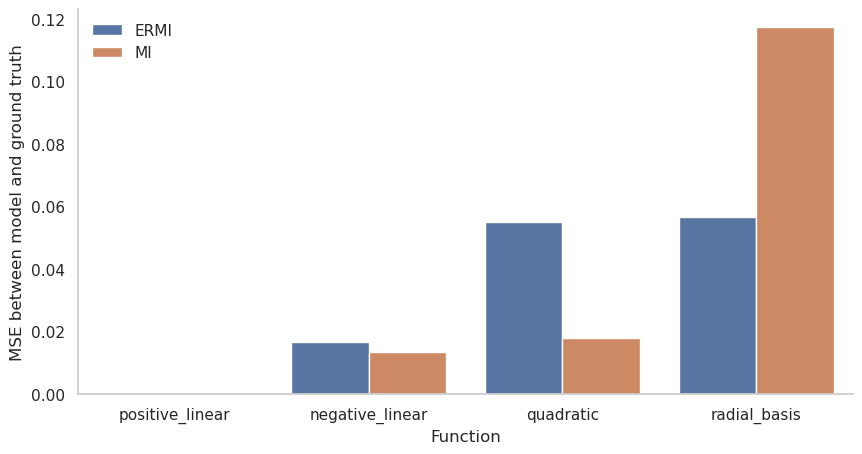

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
policy = 'greedy'

# Load the data
results_mi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic_syntheticfunctionlearning.npz')
results_ermi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/env=claude_dim1_maxsteps25_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_syntheticfunctionlearning.npz')

# Extract unique functions and calculate MSE for results_ermi
functions = ['positive_linear', 'negative_linear', 'quadratic', 'radial_basis'] #$np.unique(results_ermi['ground_truth_functions'])
error_dict_ermi = {'Function': [], 'MSE': [], 'Dataset': []}
error_dict_mi = {'Function': [], 'MSE': [], 'Dataset': []}
for function in functions:
    mse = results_ermi['model_errors'].squeeze()[(results_ermi['ground_truth_functions'] == function)].mean()
    error_dict_ermi['Function'].append(function)
    error_dict_ermi['MSE'].append(mse)
    error_dict_ermi['Dataset'].append('ERMI')
    
    mse = results_mi['model_errors'].squeeze()[(results_mi['ground_truth_functions'] == function)].mean()
    error_dict_mi['Function'].append(function)
    error_dict_mi['MSE'].append(mse)
    error_dict_mi['Dataset'].append('MI')

# Combine the data into a single DataFrame
df_ermi = pd.DataFrame(error_dict_ermi)
df_mi = pd.DataFrame(error_dict_mi)
df_combined = pd.concat([df_ermi, df_mi])

# Plot the combined data
plt.figure(figsize=(10, 5))
sns.barplot(data=df_combined, x='Function', y='MSE', hue='Dataset', capsize=.1, errorbar="sd")
sns.despine()
plt.legend(frameon=False)
plt.ylabel('MSE between model and ground truth')
plt.grid(visible=False)
plt.show()

## model comparison for Little 2024

#### errors of humans and models wrt ground truth, marginalized over all functions

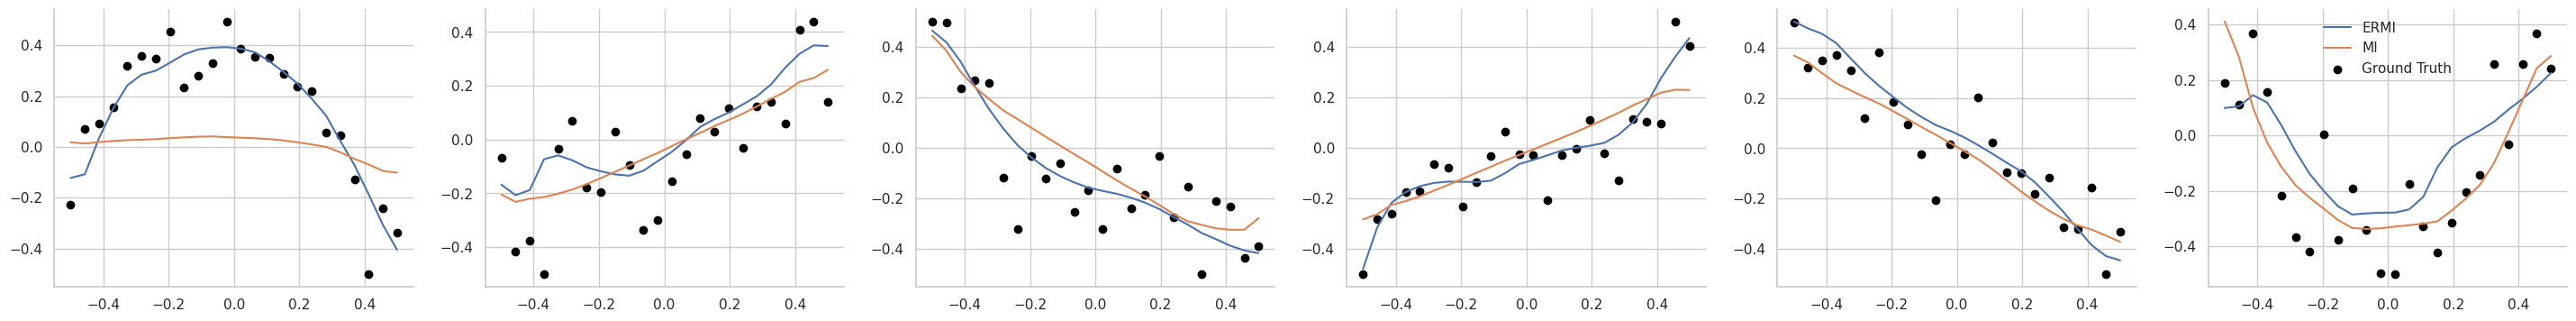

In [14]:
import seaborn as sns, matplotlib.pyplot as plt
sns.set(style="whitegrid")

data = pd.read_csv(f'/u/ajagadish/ermi/functionlearning/data/human/little2022functionestimation.csv')
num_tasks = data.task.max()+1
policy='greedy'
results_mi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic_test.npz')
results_ermi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/env=claude_dim1_maxsteps25_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_test.npz')
subject = 1
num_functions = results_ermi['human_preds'].shape[1]
num_participants=results_ermi['model_preds'].shape[0]
fig, axs = plt.subplots(1, num_functions,  figsize=(6*num_functions, 4))
for function in range(num_functions):
    axs[function].plot(results_ermi['human_preds'][subject, function, :, 0], results_ermi['model_preds'].reshape(num_participants, 6, 24)[subject, function], label='ERMI')
    axs[function].plot(results_ermi['human_preds'][subject, function, :, 0], results_mi['model_preds'].reshape(num_participants, 6, 24)[subject, function], label='MI')
    # axs[function].plot(results_ermi['human_preds'][subject, function, :, 0], results_ermi['human_preds'][subject, function, :, 1], c='green', lw=3, label='Human')
    axs[function].scatter(results_ermi['ground_truth_functions'][subject, function, :, 0],results_ermi['ground_truth_functions'][subject, function, :, 1], c='black', label="Ground Truth")
plt.legend(frameon=False)
sns.despine()
plt.show()

/tmp/ipykernel_83701/13239809.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, capsize=.1, ci="sd")
/mpcdf/soft/RHEL_9/packages/x86_64/anaconda/3/2023.03/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:0'` for same effect.
  warnings.warn(msg, FutureWarning)
/mpcdf/soft/RHEL_9/packages/x86_64/anaconda/3/2023.03/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mpcdf/soft/RHEL_9/packages/x86_64/anaconda/3/2023.03/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mpcdf

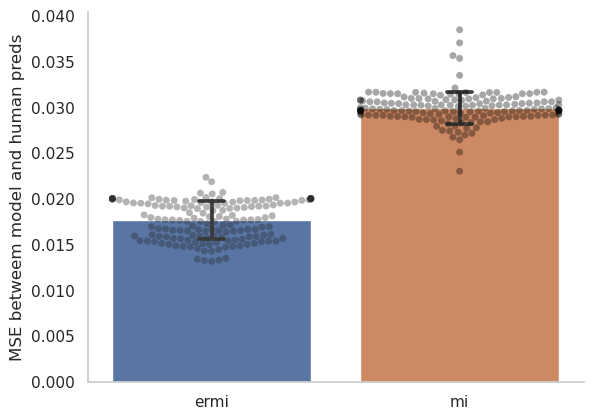

In [15]:
import seaborn as sns, matplotlib.pyplot as plt
sns.set(style="whitegrid")

data = pd.read_csv(f'/u/ajagadish/ermi/functionlearning/data/human/little2022functionestimation.csv')
num_tasks = data.task.max()+1
policy='greedy'
results_mi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic_test.npz')
results_ermi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/env=claude_dim1_maxsteps25_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_test.npz')
# tips = sns.load_dataset("tips")
df = pd.DataFrame.from_dict({'ermi':results_ermi['model_errors'].mean(1),
                             'mi':results_mi['model_errors'].mean(1),
                            })
sns.barplot(data=df, capsize=.1, ci="sd")
sns.swarmplot(data=df, color="0", alpha=.35)
sns.despine()
plt.ylabel('MSE betweem model and human preds')
plt.grid(visible=False)
plt.show() 

In [16]:
results_ermi['human_preds'][subject, function, :, 0]

array([-0.5       , -0.45658287, -0.41315509, -0.36973796, -0.32633149,
       -0.28291436, -0.23949723, -0.1960801 , -0.15265232, -0.10923519,
       -0.06581913, -0.02240094,  0.02101619,  0.06443438,  0.10785258,
        0.15126758,  0.19469536,  0.23811248,  0.28152961,  0.32494674,
        0.36835322,  0.41177035,  0.45519813,  0.49861525])

In [17]:
results_ermi['ground_truth_functions'][subject, function, :, 0]

array([-0.5       , -0.45658287, -0.41315509, -0.36973796, -0.32633149,
       -0.28291436, -0.23949723, -0.1960801 , -0.15265232, -0.10923519,
       -0.06581913, -0.02240094,  0.02101619,  0.06443438,  0.10785258,
        0.15126758,  0.19469536,  0.23811248,  0.28152961,  0.32494674,
        0.36835322,  0.41177035,  0.45519813,  0.49861525])

#### error of models wrt humans, marginalized over all functions

/tmp/ipykernel_3813376/300570529.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, capsize=.1, ci="sd")
/mpcdf/soft/RHEL_9/packages/x86_64/anaconda/3/2023.03/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:0'` for same effect.
  warnings.warn(msg, FutureWarning)


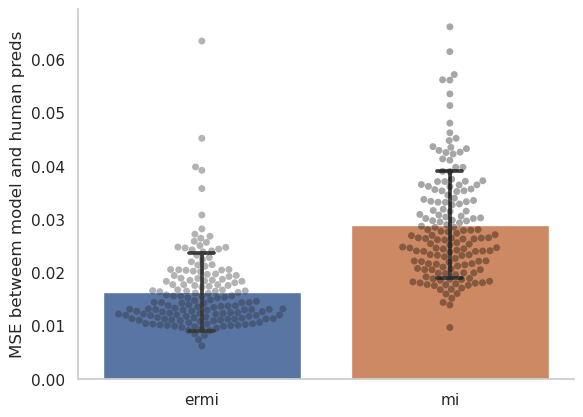

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt
sns.set(style="whitegrid")

data = pd.read_csv(f'/u/ajagadish/ermi/functionlearning/data/human/little2022functionestimation.csv')
num_tasks = data.task.max()+1
policy='greedy'
results_mi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic.npz')
results_ermi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/task=little2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy_ess=None.npz')


# tips = sns.load_dataset("tips")
df = pd.DataFrame.from_dict({'ermi':results_ermi['model_errors'].mean(1),
                             'mi':results_mi['model_errors'].mean(1),
                            })
sns.barplot(data=df, capsize=.1, ci="sd")
sns.swarmplot(data=df, color="0", alpha=.35)
sns.despine()
plt.ylabel('MSE betweem model and human preds')
plt.grid(visible=False)
plt.show() 

#### grouping errors based on type of function

quadratic
linear
cubic
cubic
linear
quadratic


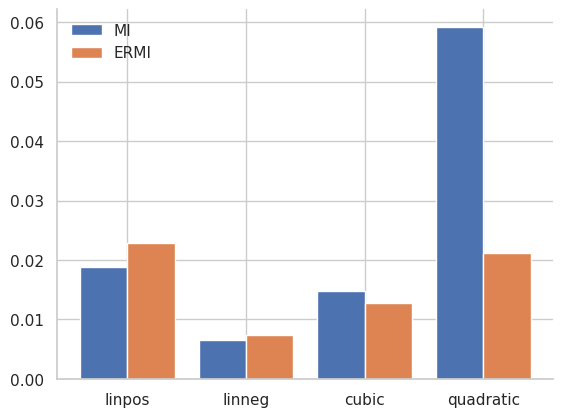

In [5]:
combined = pd.read_csv('../functionlearning/data/human/little2022functionestimation.csv')
num_points = 24 # 6 or 24
scale = 2 # 1 is zoomed in or 2 is zoomed out
subject = 1
num_functions = 6
num_data = 20
combined = combined[(combined.num_points==num_points)&(combined.scale==scale)]
sources = {1:'linear', 2: 'quadratic', 3:'cubic'}
num_participants=results_ermi['model_preds'].shape[0]

# ordering of functions
for task in np.unique(combined.task.values):
    print(sources[combined[(combined['participant']==148) & (combined['task']==task)].source.values[0]])

# works for ONLY: quad, linear, cubic, cubic, linear and quadratic
ermi_errors = results_ermi['model_errors'].reshape(num_participants, num_functions, num_data)
quad_ermi = ermi_errors[:, [0,-1]].mean()
lin_ermi = ermi_errors[:, [1]].mean()
linneg_ermi = ermi_errors[:, [-2]].mean()
cub_ermi = ermi_errors[:, [2,-3]].mean()

mi_errors = results_mi['model_errors'].reshape(num_participants, num_functions, num_data)
quad_mi = mi_errors[:, [0,-1]].mean()
lin_mi = mi_errors[:, [1]].mean()
linneg_mi = mi_errors[:, [-2]].mean()
cub_mi = mi_errors[:, [2,-3]].mean()

# Define the positions for the bars
positions = ['linpos', 'linneg', 'cubic', 'quadratic']
x = range(len(positions))
# Plot the first set of bars
plt.bar([p - 0.2 for p in x], [lin_mi, linneg_mi , cub_mi, quad_mi], width=0.4, label='MI')
# Plot the second set of bars
plt.bar([p + 0.2 for p in x], [lin_ermi, linneg_ermi, cub_ermi, quad_ermi], width=0.4, label='ERMI')
# Set the positions and labels for the x-axis
plt.xticks(x, positions)
# Add legend and remove the top and right spines
plt.legend(frameon=False)
sns.despine()
# Show the plot
plt.show()

#### individual human traces

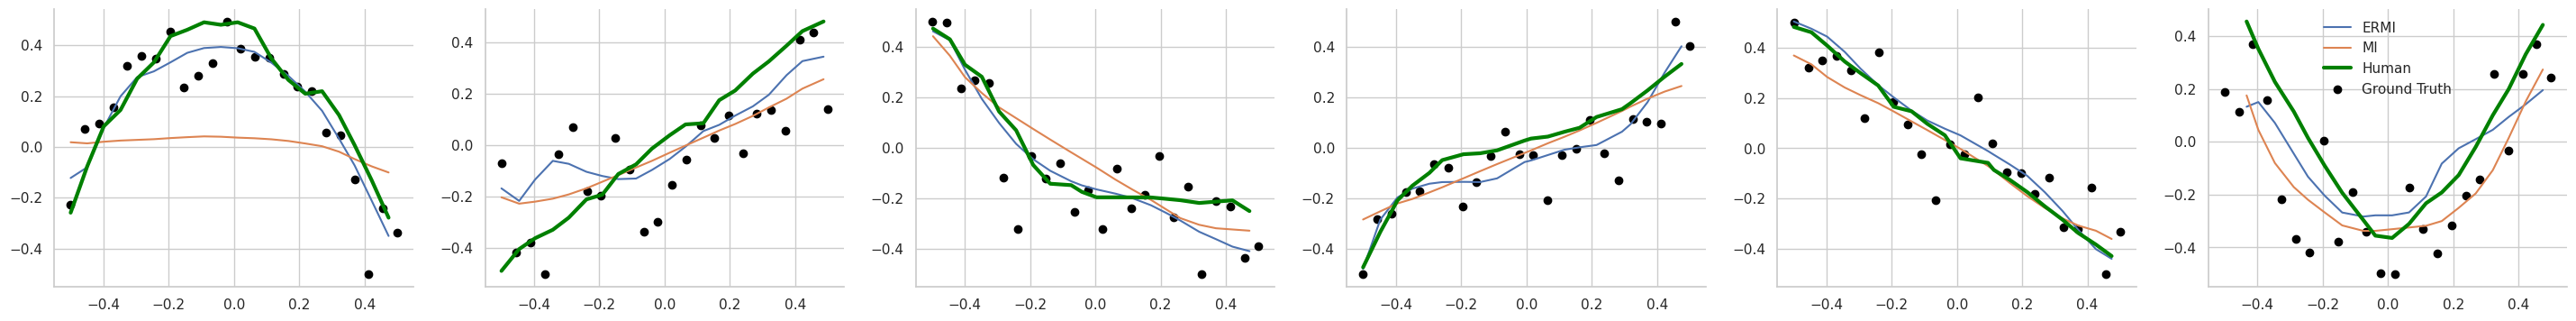

In [20]:
subject = 1
num_functions = results_ermi['human_preds'].shape[1]
num_participants=results_ermi['model_preds'].shape[0]
fig, axs = plt.subplots(1, num_functions,  figsize=(6*num_functions, 4))
for function in range(num_functions):
    axs[function].plot(results_ermi['human_preds'][subject, function, :, 0], results_ermi['model_preds'].reshape(num_participants, 6, 20)[subject, function], label='ERMI')
    axs[function].plot(results_ermi['human_preds'][subject, function, :, 0], results_mi['model_preds'].reshape(num_participants, 6, 20)[subject, function], label='MI')
    axs[function].plot(results_ermi['human_preds'][subject, function, :, 0], results_ermi['human_preds'][subject, function, :, 1], c='green', lw=3, label='Human')
    axs[function].scatter(results_ermi['ground_truth_functions'][subject, function, :, 0],results_ermi['ground_truth_functions'][subject, function, :, 1], c='black', label="Ground Truth")
plt.legend(frameon=False)
sns.despine()
plt.show()

## visualising predictions from Mi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


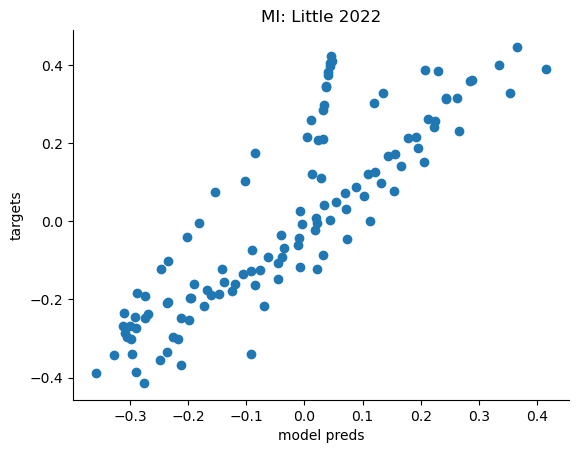

In [9]:
data = pd.read_csv(f'/u/ajagadish/ermi/functionlearning/data/human/little2022functionestimation.csv')
num_tasks = data.task.max()+1
policy='greedy'
results_mi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic.npz')

plt.scatter(results_mi['model_preds'].mean(0), results_ermi['targets'].mean(0))                             
plt.ylabel('targets')
plt.xlabel('model preds')
sns.despine()
plt.legend(loc='lower right')
plt.title(f"MI: Little 2022")
plt.legend(frameon=False)
plt.show()

In [90]:
results_ermi['targets'].shape

(157, 120)

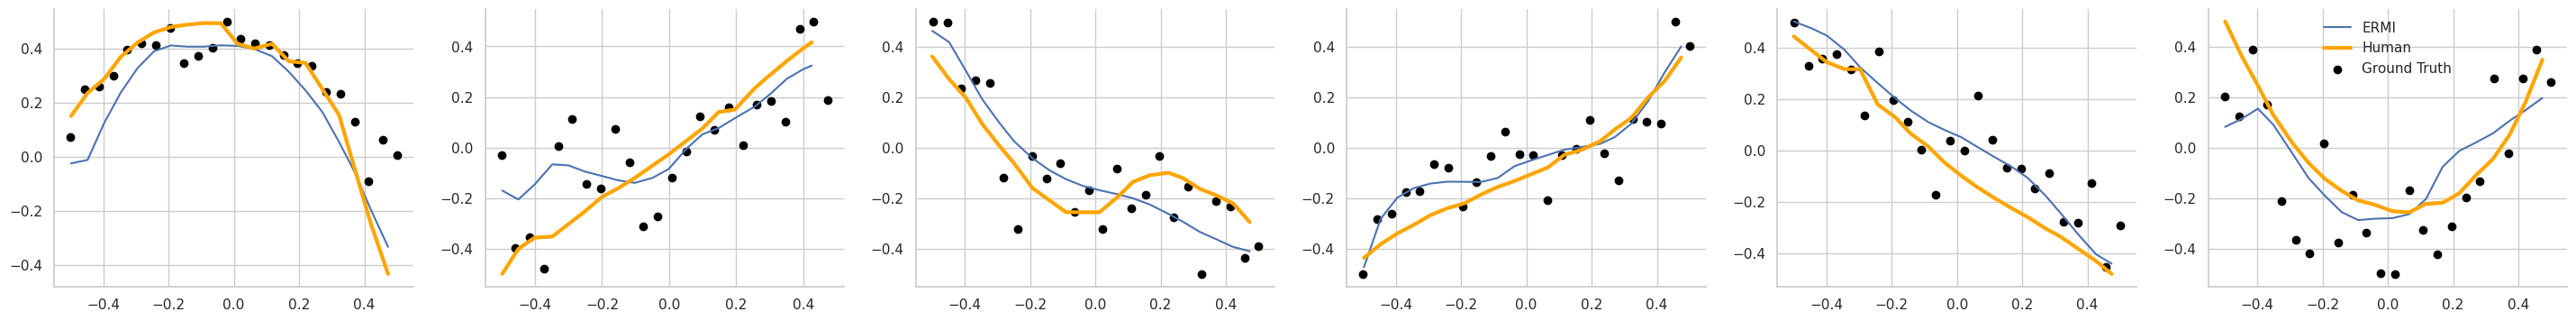

In [95]:
subject = 67
num_functions = results_ermi['human_preds'].shape[1]
num_participants=results_ermi['model_preds'].shape[0]
fig, axs = plt.subplots(1, num_functions,  figsize=(6*num_functions, 4))
for function in range(num_functions):
    axs[function].plot(results_ermi['human_preds'][subject, function, :, 0], results_ermi['model_preds'].reshape(num_participants, 6, 20)[subject, function], label='ERMI') 
    axs[function].plot(results_ermi['human_preds'][subject, function, :, 0], results_ermi['human_preds'][subject, function, :, 1], c='orange', lw=3, label='Human')
    axs[function].scatter(results_ermi['ground_truth_functions'][subject, function, :, 0],results_ermi['ground_truth_functions'][subject, function, :, 1], c='black', label="Ground Truth")
plt.legend(frameon=False)
sns.despine()
plt.show()

## visualising predictions from ERMI

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


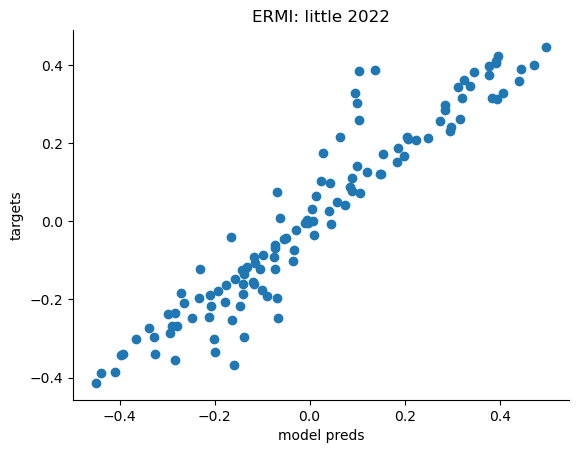

In [7]:
data = pd.read_csv(f'/u/ajagadish/ermi/functionlearning/data/human/little2022functionestimation.csv')
num_tasks = data.task.max()+1
policy='greedy'
results_ermi = np.load(f'/u/ajagadish/ermi/functionlearning/data/model_simulation/task=little2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy_ess=None.npz')

plt.scatter(results_ermi['model_preds'].mean(0), results_ermi['targets'].mean(0))                             
plt.ylabel('targets')
plt.xlabel('model preds')
sns.despine()
plt.legend(loc='lower right')
plt.title(f"ERMI: little 2022")
plt.legend(frameon=False)
plt.show()

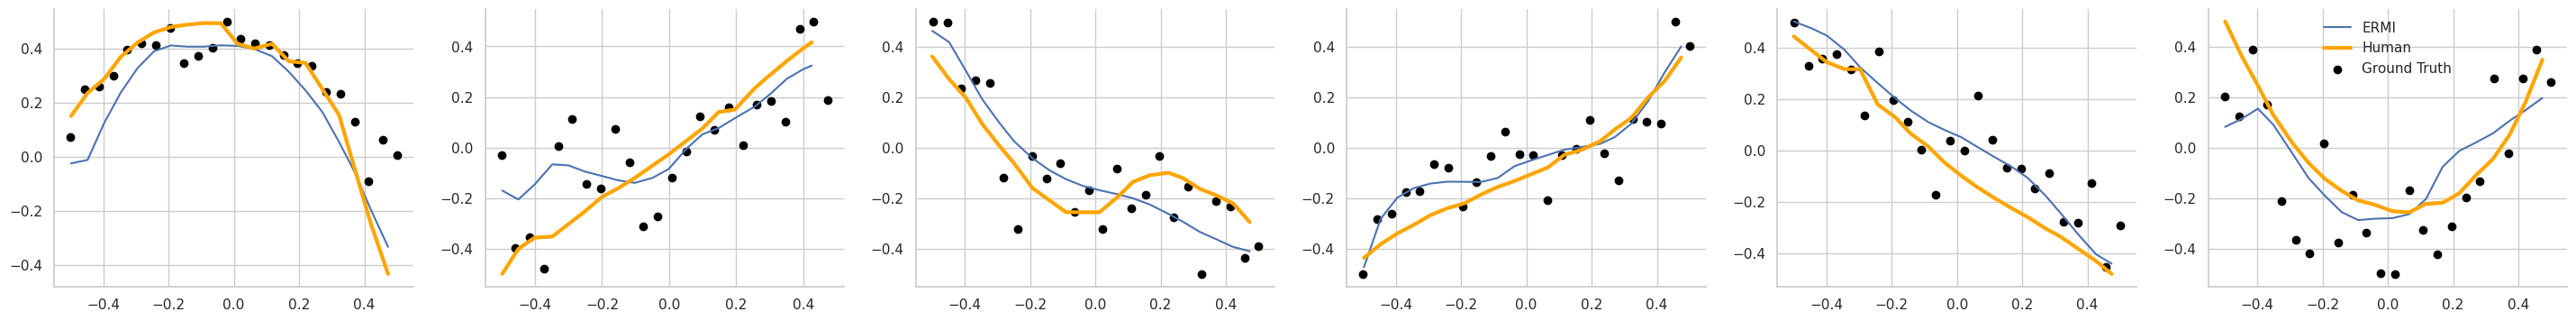

In [69]:
subject = 67
num_functions = results_ermi['human_preds'].shape[1]
num_participants=results_ermi['model_preds'].shape[0]
fig, axs = plt.subplots(1, num_functions,  figsize=(6*num_functions, 4))
for function in range(num_functions):
    axs[function].plot(results_ermi['human_preds'][subject, function, :, 0], results_ermi['model_preds'].reshape(num_participants, 6, 20)[subject, function], label='ERMI') 
    axs[function].plot(results_ermi['human_preds'][subject, function, :, 0], results_ermi['human_preds'][subject, function, :, 1], c='orange', lw=3, label='Human')
    axs[function].scatter(results_ermi['ground_truth_functions'][subject, function, :, 0],results_ermi['ground_truth_functions'][subject, function, :, 1], c='black', label="Ground Truth")
plt.legend(frameon=False)
sns.despine()
plt.show()

/tmp/ipykernel_114140/3665226524.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(y='ermi=0.5', data=df, capsize=.1, ci="sd")


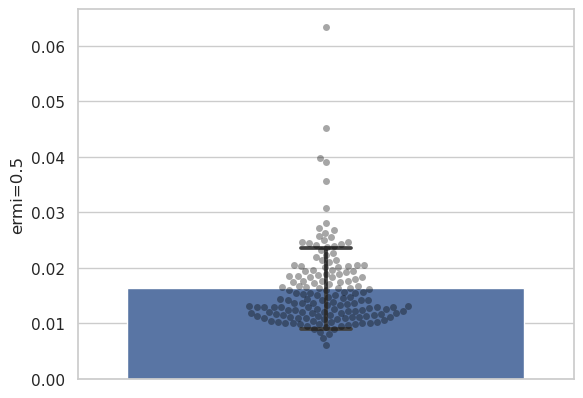

In [62]:
import seaborn as sns, matplotlib.pyplot as plt
sns.set(style="whitegrid")

# tips = sns.load_dataset("tips")
df = pd.DataFrame.from_dict({'ermi=0.5':results_ermi['model_errors'].mean(1),
                             # 'ermi=0.5':results_ermi_norm05['model_errors'].mean(1),
                             # 'ermi=1.25':results_ermi_norm125['model_errors'].mean(1),
                            })
sns.barplot(y='ermi=0.5', data=df, capsize=.1, ci="sd")
sns.swarmplot(y='ermi=0.5',data=df, color="0", alpha=.35)

plt.show() 

## visualising functions from Little 2024

In [21]:
combined = pd.read_csv('../functionlearning/data/human/little2022functionestimation.csv')

In [151]:
combined.x.min(), combined.x.max()

(-0.8418, 0.8458)

In [152]:
combined.y.min(), combined.y.max()

(-1.2431, 1.0106)

In [60]:
combined = pd.read_csv('../functionlearning/data/human/little2022functionestimation.csv')
num_points = 24 # 6 or 24
scale = 2 # 1 is zoomed in or 2 is zoomed out
subject = 1
combined = combined[(combined.num_points==num_points)&(combined.scale==scale)]
sources = {1:'linear', 2: 'quadratic', 3:'cubic'}

In [82]:
for task in np.unique(combined.task.values):
    print(sources[combined[(combined['participant']==148) & (combined['task']==task)].source.values[0]])

quadratic
linear
cubic
cubic
linear
quadratic


In [61]:
np.unique(combined[(combined['participant']==subject)].task.values)

array([10, 13, 17, 18, 19, 24])

In [62]:
combined.groupby('participant').filter(lambda x: len(x.task.unique()) == 6)

,Unnamed: 0,participant,task,x,y,num_points,scale,source,type
84,84,1,10,-0.40000,-0.144460,24,2,2,train
85,85,1,10,-0.36522,0.060363,24,2,2,train
86,86,1,10,-0.33043,0.074774,24,2,2,train
87,87,1,10,-0.29565,0.120050,24,2,2,train
88,88,1,10,-0.26087,0.231730,24,2,2,train
...,...,...,...,...,...,...,...,...,...
2472799,2412475,170,24,0.43880,0.608200,24,2,2,test
2472800,2412476,170,24,0.43880,0.608200,24,2,2,test
2472801,2412477,170,24,0.43880,0.608200,24,2,2,test
2472802,2412478,170,24,0.43880,0.608200,24,2,2,test


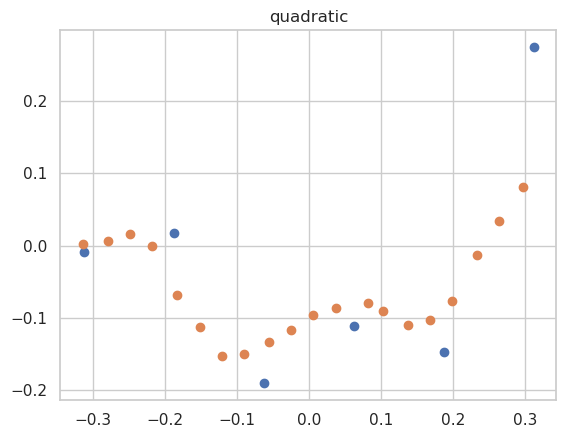

In [35]:
task = 26
df_stimuli = combined[(combined['participant']==subject) & (combined.task==task) & (combined.type=='train')]
df_choices = combined[(combined['participant']==subject) & (combined.task==task) & (combined.type=='test')]
source = sources[df_stimuli.source.values[0]]
plt.scatter(df_stimuli.x,df_stimuli.y)
plt.scatter(df_choices.x[::12],df_choices.y[::12])
# plt.scatter(df_choices.x[::24],df_choices.y[::24])
# plt.scatter(df_choices.x[::48],df_choices.y[::48])

plt.title(f'{source}')
plt.show()

In [27]:
960/48

20.0

In [ ]:
df_choices

### preprocessing little2022

In [23]:
stimuli = pd.read_csv('../functionlearning/data/human/Little2022_stimuli.csv')
choices = pd.read_csv('../functionlearning/data/human/Little2022_choices.csv')
num_points = 24 # 6 or 24
scale = 2 # 1 is zoomed in or 2 is zoomed out
subject = 23
stimuli = stimuli#[(stimuli.num_points==num_points)&(stimuli.scale==scale)]
sources = {1:'linear', 2: 'quadratic', 3:'cubic'}

In [24]:
np.unique(stimuli[(stimuli['participant']==subject)].task.values)

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 22, 23, 24, 25, 26])

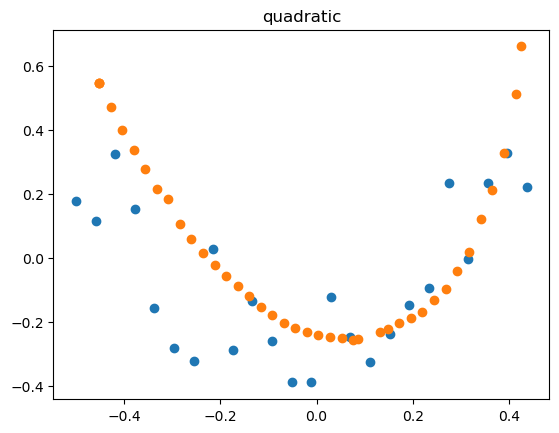

In [25]:
task = 24
df_stimuli = stimuli[(stimuli['participant']==subject) & (stimuli.task==task)]
df_choices = choices[(choices['participant']==subject) & (choices.task==task)]
source = sources[df_stimuli.source.values[0]]
plt.scatter(df_stimuli.x,df_stimuli.y)
plt.scatter(df_choices.x,df_choices.y)
plt.title(f'{source}')
plt.show()

## visualising synthesized functions based on priors from Lucas 2015

In [8]:
data = pd.read_csv('../functionlearning/data/generated_tasks/synthetic_functionlearning_tasks_dim1_data25_tasks10000.csv')

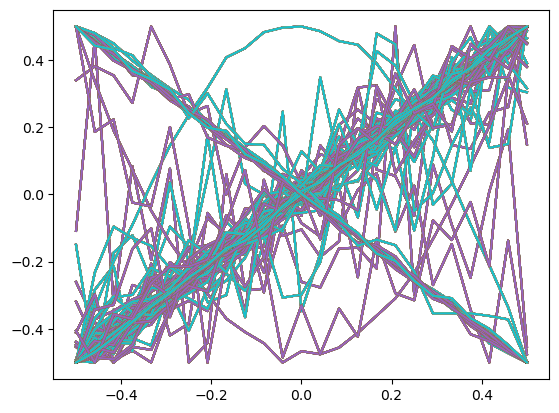

In [12]:
for task_id in data.task_id.values[:5000]:
    d =data[data.task_id==task_id]
    plt.plot(d.input.values ,d.target.values)

# visualising real data

In [24]:
df = pd.read_csv(f'{SYS_PATH}/functionlearning/real_data.csv')
num_tasks = 10
random_tasks = np.arange(num_tasks)#np.random.randint(low=df['task_id'].min(), high=df['task_id'].max(), size=num_tasks)
# keep only first 100 tasks
df = df[df['task_id'].isin(random_tasks)]
df['input'] = df['input'].apply(lambda x: eval(x)[0])
df['target'] = df['target'].apply(lambda x: eval(x)[0])
# divide input by max value for each task
df['input'] = df.apply(lambda x: (x['input']-df[df['task_id']==x['task_id']]['input'].min())/(df[df['task_id']==x['task_id']]['input'].max()-df[df['task_id']==x['task_id']]['input'].min()+1e-6), axis=1)
df['target'] = df.apply(lambda x:(x['target']-df[df['task_id']==x['task_id']]['target'].min())/(df[df['task_id']==x['task_id']]['target'].max()-df[df['task_id']==x['task_id']]['target'].min()+1e-6), axis=1)

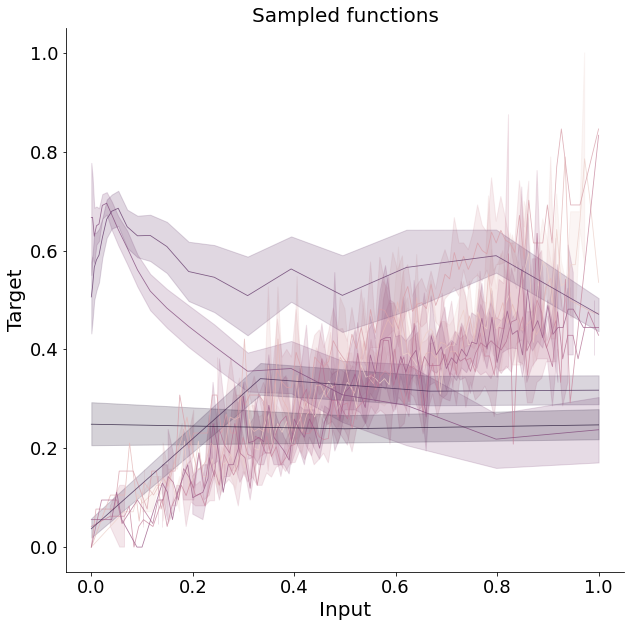

In [25]:
# plot scatter plot of input vs target colored by task
plt.figure(figsize=(10,10))
sns.lineplot(x='input', y='target', hue='task_id', data=df, legend=False, alpha=0.8, linewidth=0.8)
plt.xlabel('Input', fontsize=FONTSIZE)
plt.ylabel('Target', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.title('Sampled functions', fontsize=FONTSIZE)
sns.despine()
plt.show()

# visualising LLM generated functions

In [119]:
df = pd.read_csv(f'{SYS_PATH}/functionlearning/data/generated_tasks/claude_generated_functionlearningtasks_paramsNA_dim1_data20_tasks9991_run0_procid0_pversion2.csv')
num_tasks = 200
random_tasks = np.arange(num_tasks)#np.random.randint(low=df['task_id'].min(), high=df['task_id'].max(), size=num_tasks)
# keep only first 100 tasks
df = df[df['task_id'].isin(random_tasks)]
df['input'] = df['input'].apply(lambda x: eval(x)[0])
# devide input by max value for each task
df['input'] = df.apply(lambda x: (x['input']-df[df['task_id']==x['task_id']]['input'].min())/(df[df['task_id']==x['task_id']]['input'].max()-df[df['task_id']==x['task_id']]['input'].min()+1e-6), axis=1)
df['target'] = df.apply(lambda x:(x['target']-df[df['task_id']==x['task_id']]['target'].min())/(df[df['task_id']==x['task_id']]['target'].max()-df[df['task_id']==x['task_id']]['target'].min()+1e-6), axis=1)

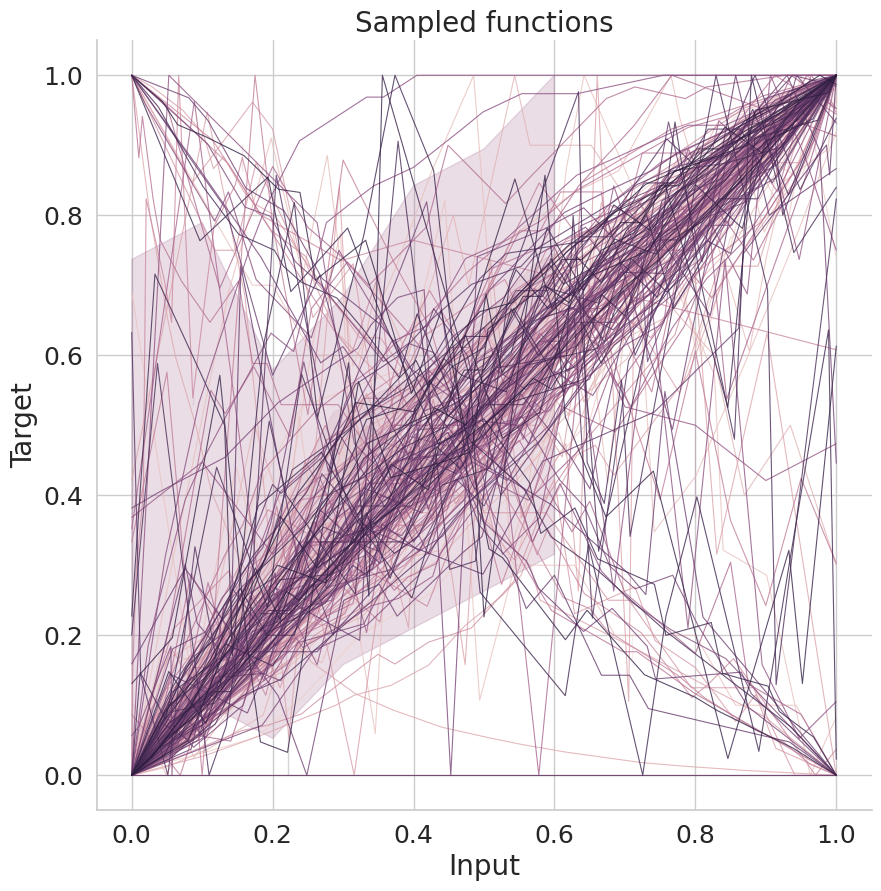

In [120]:
# plot scatter plot of input vs target colored by task
plt.figure(figsize=(10,10))
sns.lineplot(x='input', y='target', hue='task_id', data=df, legend=False, alpha=0.8, linewidth=0.8)
plt.xlabel('Input', fontsize=FONTSIZE)
plt.ylabel('Target', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.title('Sampled functions', fontsize=FONTSIZE)
sns.despine()
plt.show()


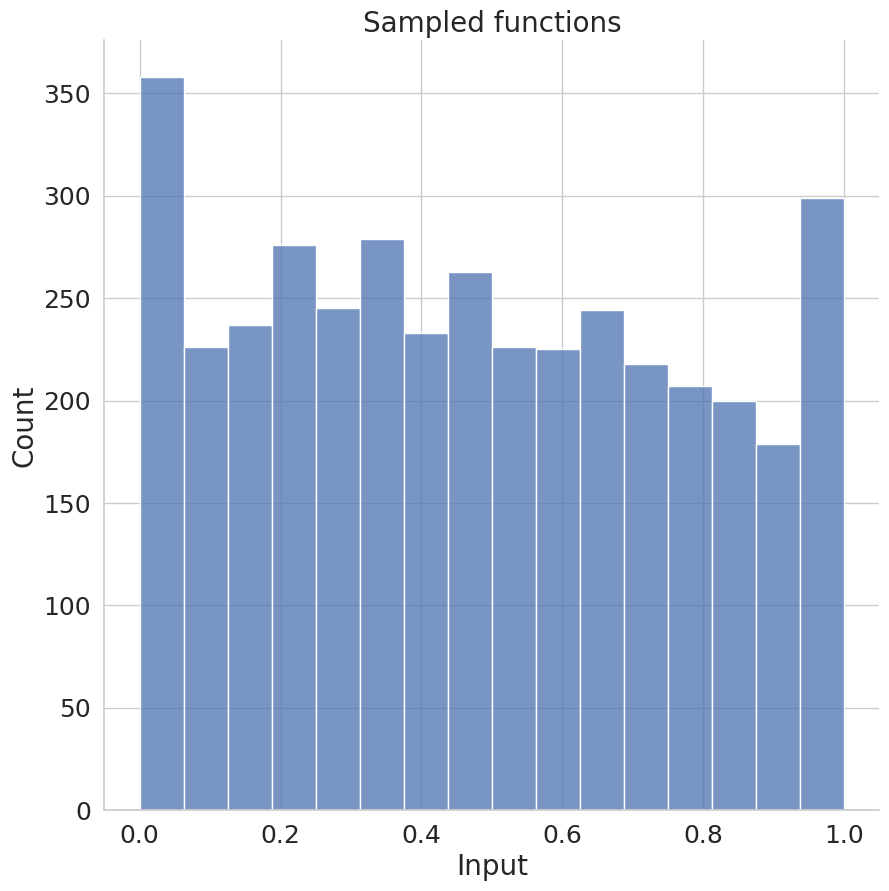

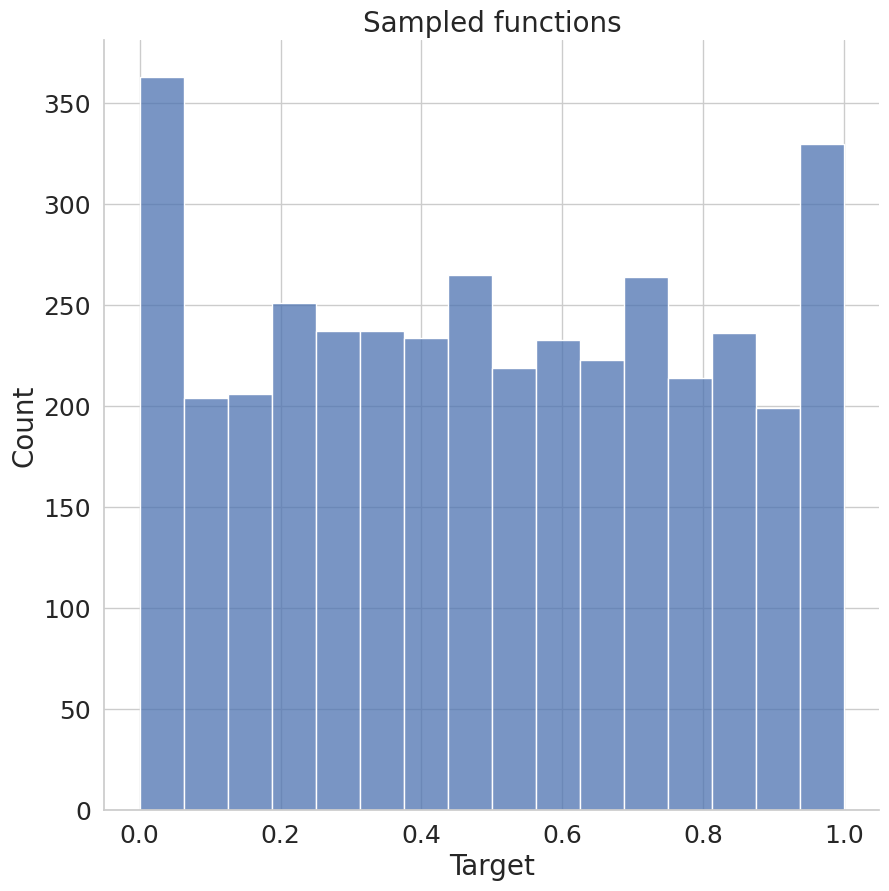

In [121]:
# plot scatter plot of input vs target colored by task
plt.figure(figsize=(10,10))
sns.histplot(data=df, x='input')
plt.xlabel('Input', fontsize=FONTSIZE)
plt.ylabel('Count', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.title('Sampled functions', fontsize=FONTSIZE)
sns.despine()
plt.show()

plt.figure(figsize=(10,10))
sns.histplot(data=df, x='target')
plt.xlabel('Target', fontsize=FONTSIZE)
plt.ylabel('Count', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE-2)
plt.title('Sampled functions', fontsize=FONTSIZE)
sns.despine()
plt.show()


### number of tasks with zero offset

In [122]:
df = pd.read_csv(f'{SYS_PATH}/functionlearning/data/generated_tasks/claude_generated_functionlearningtasks_paramsNA_dim1_data20_tasks9991_run0_procid0_pversion2.csv')
# num_tasks = 10000
# random_tasks = np.random.randint(low=df['task_id'].min(), high=df['task_id'].max(), size=num_tasks)
# # keep only first 100 tasks
# df = df[df['task_id'].isin(random_tasks)]
df['input'] = df['input'].apply(lambda x: eval(x)[0])
# devide input by max value for each task
# df['input'] = df.apply(lambda x: (x['input']-df[df['task_id']==x['task_id']]['input'].min())/(df[df['task_id']==x['task_id']]['input'].max()-df[df['task_id']==x['task_id']]['input'].min()+1e-6), axis=1)
# df['target'] = df.apply(lambda x:(x['target']-df[df['task_id']==x['task_id']]['target'].min())/(df[df['task_id']==x['task_id']]['target'].max()-df[df['task_id']==x['task_id']]['target'].min()+1e-6), axis=1)

In [ ]:
aa = np.array([df[df.task_id==task_id].input.min() for task_id in np.unique(df.task_id.values)])
aa = aa[aa==0]

In [ ]:
plt.hist(aa)

# testing prompt

In [71]:
def synthesize_functionlearning_problems(model, version, num_dim=1, num_tasks=100):

    instructions = {}
    features_to_text = {1: 'a real-world feature is mapped to its corresponding target, with both feature and target taking on continuous values', 2: 'two real-world features are mapped to their corresponding target, with features and target taking on continuous values'}
    format_to_text = {1: '- feature name, target name', 2: '- feature name 1, feature name 2, target name'}
    synthesize_feature_names_prompt_v0  = f" I am a psychologist who wants to run a function learning experiment. "\
                 f"In a function learning experiment, {features_to_text[num_dim]}."\
                 f" Please generate names for features and its corresponding target for {str(num_tasks)} different function learning experiments: \n"\
                 f"{format_to_text[num_dim]} \n"  
    
    instructions['claude'] = {}
    instructions['claude']['v0'] = synthesize_feature_names_prompt_v0

    
    return instructions[model][version]

In [76]:
print(synthesize_functionlearning_problems(model='claude', version='v0', num_dim=1))

 I am a psychologist who wants to run a function learning experiment. In a function learning experiment, a real-world feature is mapped to its corresponding target, with both feature and target taking on continuous values. Please generate names for features and its corresponding target for 100 different function learning experiments: 
- feature name, target name 



In [77]:
def synthesize_decisionmaking_problems(model, version, num_dim=2, num_tasks=100):

    instructions = {}
    features_to_text = {1: 'a real-world feature is mapped to its corresponding target, with both feature and target taking on continuous values', 2: 'two real-world features are mapped to their corresponding target, with features and target taking on continuous values'}
    format_to_text = {1: '- feature name, target name', 2: '- feature name 1, feature name 2, target name'}
    synthesize_feature_names_prompt_v0  = f" I am a psychologist who wants to run a decision-making experiment. "\
                 f"In a decision-making experiment, {features_to_text[num_dim]}."\
                 f" Please generate names for features and its corresponding target for {str(num_tasks)} different decision-making experiments: \n"\
                 f"{format_to_text[num_dim]} \n"  
    
    instructions['claude'] = {}
    instructions['claude']['v0'] = synthesize_feature_names_prompt_v0

    
    return instructions[model][version]

In [79]:
print(synthesize_decisionmaking_problems(model='claude', version='v0', num_dim=2))

 I am a psychologist who wants to run a decision-making experiment. In a decision-making experiment, two real-world features are mapped to their corresponding target, with features and target taking on continuous values. Please generate names for features and its corresponding target for 100 different decision-making experiments: 
- feature name 1, feature name 2, target name 



In [11]:
def generate_data_functionlearning(model, version, num_dim=3, num_data=20, features=None, categories=None):

    instructions = {}
    
    # num_to_text = {2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight'}
    # def featurenames_to_text(features,targets, num_dim):
    #     if num_dim==3:
    #         return f'{features[0]}, {features[1]}, and {features[2]}', {targets}
    #     elif num_dim==4:
    #         return f'{features[0]}, {features[1]}, {features[2]}, {features[3]}'
    #     elif num_dim==6:
    #         return f'{features[0]}, {features[1]}, {features[2]}, {features[3]}, {features[4]}, and {features[5]}'
    instructions['claude'] = {}
    feature, target = 'Game difficulty', 'Game engagement'
    generate_data_prompt_v1 = f" I am a psychologist who wants to run a function learning experiment."\
                          " For a function learning experiment, I need a list of feature and target pairs."\
                         f" The feature and target in this case are {feature.lower()} and {target.lower()} respectively."\
                         f" The feature can take only numerical values and must be continuous."\
                         f" {target.capitalize()} should be predictable from the feature and must also take on continuous values."\
                          " \n\n"\
                        f" Please generate a list of {str(num_data)} feature-target pairs"\
                         " sequentially using the following template for each row: \n"\
                        f" 1: {feature.lower()} value, {target.lower()} value \n"\
                        f"Please do not skip any row; values taken by features and target do not need to be ordered."
    
    # instructions['claude']['v0'] = generate_data_prompt_v0
    instructions['claude']['v1'] = generate_data_prompt_v1
    # print(instructions)
    return instructions[model][version]

In [65]:
def generate_data_functionlearning_problems(model, version, num_data=20, features=None, target=None):

    instructions = {}
    instructions['claude'] = {}
    num_dim=len(features)
    # feature, target = 'Game difficulty', 'Game engagement'
#     generate_data_prompt_v0 = f" I am a psychologist who wants to run a function learning experiment."\
#                           " For a function learning experiment, I need a list of feature and target pairs."\
#                          f" The feature and target in this case are {features.lower()} and {target.lower()} respectively."\
#                          f" {features.capitalize()} can take only numerical values and must be continuous."\
#                          f" {target.capitalize()} should be predictable from the {features.lower()} and must also take on continuous values."\
#                           " \n\n"\
#                         f" Please generate a list of {str(num_data)} feature-target pairs"\
#                          " sequentially using the following template for each row: \n"\
#                         f" 1: {features.lower()} value, {target.lower()} value \n"\
#                         f"Please do not skip any row; values taken by {features.lower()} and {target.lower()} do not need to be ordered."
#.    instructions['claude']['v0'] = generate_data_prompt_v0
    
#     generate_data_prompt_v1 = f" I am a psychologist who wants to run a function learning experiment."\
#                           " For a function learning experiment, I need a list of feature and target pairs."\
#                          f" The feature and target in this case are {features.lower()} and {target.lower()} respectively."\
#                          f" The feature can take only numerical values and must be continuous."\
#                          f" {target.capitalize()} should be predictable from the feature and must also take on continuous values."\
#                           " \n\n"\
#                         f" Please generate a list of {str(num_data)} feature-target pairs"\
#                          " sequentially using the following template for each row: \n"\
#                         f" 1: {features.lower()} value, {target.lower()} value \n"\
#                         f"Please do not skip any row; values taken by features and target do not need to be ordered."
    # instructions['claude']['v1'] = generate_data_prompt_v1
    
    def featurenames_to_text(features, num_dim):
        if num_dim==1:
            return f'feature in this case is {features[0].lower()}', 'The feature takes', '- feature value, target value'
        elif num_dim==2:
            return f'features in this case are {features[0].lower()} and {features[1].lower()}', 'These features take', '- feature value 1, feature value 2, target value'
        
    feature_text, style, template = featurenames_to_text(features, num_dim)
        
    generate_data_prompt_v2 = f" I am a psychologist who wants to run a function learning experiment."\
                          " For a function learning experiment, I need a list of features with their corresponding target."\
                         f" The {feature_text}."\
                         f" {style} on only numerical values and must be continuous."\
                         f" The target, {target.lower()}, should be predictable from the feature values and must also take on continuous values."\
                          " \n\n"\
                         f" Please generate a list of {str(num_data)} feature-target pairs"\
                          " sequentially using the following template for each row: \n"\
                         f" {template} \n"\
                         f" Please do not skip any row; values taken by features and targets do not need to be ordered."
    
    
   
    instructions['claude']['v2'] = generate_data_prompt_v2
    
    return instructions[model][version]

In [68]:
def generate_data_functionlearning_problems(model, version, num_data=20, num_dim=1, features=None, target=None):

    instructions = {}
    instructions['claude'] = {}
    # feature, target = 'Game difficulty', 'Game engagement'
    generate_data_prompt_v0 = f" I am a psychologist who wants to run a function learning experiment."\
                          " For a function learning experiment, I need a list of feature and target pairs."\
                         f" The feature and target in this case are {features[0].lower()} and {target.lower()} respectively."\
                         f" {features[0].capitalize()} can take only numerical values and must be continuous."\
                         f" {target.capitalize()} should be predictable from the {features[0].lower()} and must also take on continuous values."\
                          " \n\n"\
                        f" Please generate a list of {str(num_data)} feature-target pairs"\
                         " sequentially using the following template for each row: \n"\
                        f" 1: {features[0].lower()} value, {target.lower()} value \n"\
                        f"Please do not skip any row; values taken by {features[0].lower()} and {target.lower()} do not need to be ordered."
    
    generate_data_prompt_v1 = f" I am a psychologist who wants to run a function learning experiment."\
                          " For a function learning experiment, I need a list of feature and target pairs."\
                         f" The feature and target in this case are {features[0].lower()} and {target.lower()} respectively."\
                         f" The feature can take only numerical values and must be continuous."\
                         f" {target.capitalize()} should be predictable from the feature and must also take on continuous values."\
                          " \n\n"\
                        f" Please generate a list of {str(num_data)} feature-target pairs"\
                         " sequentially using the following template for each row: \n"\
                        f" 1: {features[0].lower()} value, {target.lower()} value \n"\
                        f"Please do not skip any row; values taken by features and target do not need to be ordered."
    
    def featurenames_to_text(features, num_dim):
        if num_dim==1:
            return f'feature in this case is {features[0].lower()}', 'The feature takes', '- feature value, target value'
        elif num_dim==2:
            return f'features in this case are {features[0].lower()} and {features[1].lower()}', 'These features take', '- feature value 1, feature value 2, target value'
        
    feature_text, style, template = featurenames_to_text(features, num_dim)
    generate_data_prompt_v2 = f" I am a psychologist who wants to run a function learning experiment."\
                          " For a function learning experiment, I need a list of features with their corresponding target."\
                         f" The {feature_text}."\
                         f" {style} on only numerical values and must be continuous."\
                         f" The target, {target.lower()}, should be predictable from the feature values and must also take on continuous values."\
                          " \n\n"\
                         f" Please generate a list of {str(num_data)} feature-target pairs"\
                          " sequentially using the following template for each row: \n"\
                         f" {template} \n"\
                         f" Please do not skip any row; values taken by features and targets do not need to be ordered."
    
    instructions['claude']['v0'] = generate_data_prompt_v0
    instructions['claude']['v1'] = generate_data_prompt_v1
    instructions['claude']['v2'] = generate_data_prompt_v2
    
    return instructions[model][version]

In [69]:
print(generate_data_functionlearning_problems(model='claude', version='v2', features=['Height'], target='Weight'))

 I am a psychologist who wants to run a function learning experiment. For a function learning experiment, I need a list of features with their corresponding target. The feature in this case is height. The feature takes on only numerical values and must be continuous. The target, weight, should be predictable from the feature values and must also take on continuous values. 

 Please generate a list of 20 feature-target pairs sequentially using the following template for each row: 
 - feature value, target value 
 Please do not skip any row; values taken by features and targets do not need to be ordered.


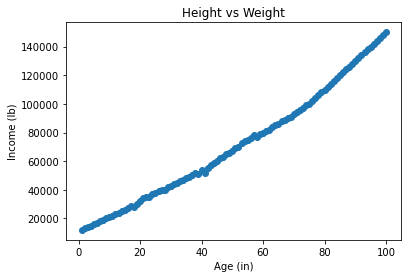

In [53]:
import matplotlib.pyplot as plt

heights = [32, 41, 28, 50, 23, 19, 55, 47, 29, 36, 62, 24, 18, 39, 45, 60, 33, 26, 42, 38, 48, 27, 58, 54, 49, 20, 53, 46, 43, 64, 21, 51, 63, 40, 30, 37, 59, 35, 56, 31, 44, 61, 25, 17, 52, 34, 65, 22, 16, 57, 15, 66, 67, 68, 69, 70, 14, 71, 13, 72, 12, 73, 11, 10, 74, 9, 75, 8, 76, 7, 77, 6, 78, 5, 79, 4, 80, 3, 81, 2, 82, 1, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100] 

weights = [45000, 52000, 40000, 67000, 35000, 30000, 75000, 63000, 42000, 49000, 82000, 37000, 28000, 51000, 60000, 80000, 46000, 39000, 55000, 52000, 65000, 40000, 77000, 74000, 66000, 32000, 73000, 62000, 57000, 85000, 34000, 69000, 84000, 54000, 43000, 50000, 79000, 48000, 76000, 44000, 59000, 81000, 38000, 29000, 70000, 47000, 86000, 35000, 27000, 78000, 26000, 88000, 89000, 90000, 91000, 93000, 25000, 94000, 24000, 96000, 23000, 97000, 22000, 21000, 99000, 20000, 100000, 19000, 102000, 18000, 104000, 17000, 106000, 16000, 108000, 15000, 110000, 14000, 112000, 13000, 114000, 12000, 116000, 118000, 120000, 122000, 124000, 126000, 128000, 130000, 132000, 134000, 136000, 138000, 140000, 142000, 144000, 146000, 148000, 150000]

plt.scatter(heights, weights)
plt.xlabel('Age (in)')
plt.ylabel('Income (lb)')
plt.title('Height vs Weight')
plt.show()

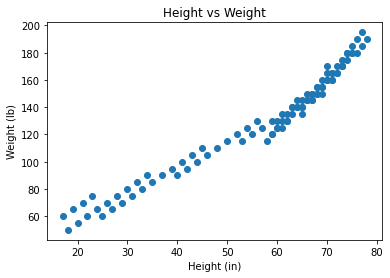

In [54]:
import matplotlib.pyplot as plt

heights = [65, 72, 68, 74, 70, 66, 62, 60, 71, 69, 67, 73, 75, 61, 64, 63, 59, 58, 76, 70, 68, 72, 74, 77, 65, 73, 71, 69, 67, 75, 62, 60, 64, 66, 70, 68, 61, 59, 63, 65, 69, 67, 71, 73, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 77, 75, 73, 71, 69, 67, 65, 63, 61, 59, 57, 55, 53, 56, 54, 52, 50, 48, 46, 44, 42, 40, 45, 43, 41, 39, 37, 35, 33, 31, 29, 27, 25, 34, 32, 30, 28, 26, 24, 22, 20, 18, 23, 21, 19, 17]

weights = [140, 165, 155, 180, 170, 150, 135, 130, 160, 160, 145, 175, 185, 125, 145, 140, 120, 115, 190, 165, 150, 170, 180, 195, 135, 170, 165, 155, 150, 180, 130, 125, 140, 145, 160, 155, 130, 120, 135, 140, 150, 145, 165, 170, 125, 130, 140, 145, 150, 160, 165, 175, 180, 190, 185, 180, 170, 160, 155, 150, 145, 140, 135, 130, 125, 120, 115, 130, 125, 120, 115, 110, 105, 100, 95, 90, 110, 105, 100, 95, 90, 85, 80, 75, 70, 65, 60, 90, 85, 80, 75, 70, 65, 60, 55, 50, 75, 70, 65, 60]

plt.scatter(heights, weights)
plt.xlabel('Height (in)')
plt.ylabel('Weight (lb)')
plt.title('Height vs Weight')
plt.show()

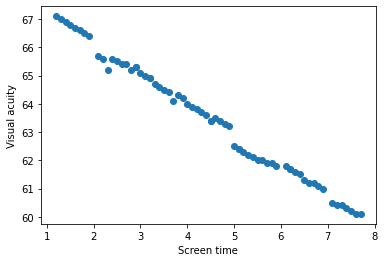

In [70]:
import matplotlib.pyplot as plt

x = [2.3, 5.1, 3.7, 4.9, 6.2, 1.5, 3.2, 4.6, 5.4, 7.1, 2.9, 6.7, 1.8, 5.8, 3.4, 2.1, 4.2, 6.3, 5.2, 3.1, 7.5, 4.3, 2.7, 6.1, 3.9, 5.6, 1.2, 4.7, 6.9, 2.5, 3.3, 5.0, 7.3, 1.6, 4.1, 2.8, 6.5, 3.5, 4.4, 5.7, 1.9, 2.4, 6.8, 3.8, 4.8, 7.7, 5.9, 1.3, 2.2, 4.5, 6.4, 3.0, 5.3, 7.4, 1.7, 4.0, 2.6, 6.2, 5.5, 3.6, 7.2, 1.4, 4.5, 2.9, 6.6, 5.1, 3.2, 7.6]

y = [65.2, 62.4, 64.1, 63.2, 61.7, 66.8, 64.9, 63.5, 62.1, 60.5, 65.3, 61.2, 66.5, 61.9, 64.6, 65.7, 63.8, 61.6, 62.3, 65.0, 60.2, 63.7, 65.4, 61.8, 64.2, 62.0, 67.1, 63.4, 61.0, 65.5, 64.7, 62.5, 60.4, 66.7, 63.9, 65.2, 61.3, 64.5, 63.6, 61.9, 66.4, 65.6, 61.1, 64.3, 63.3, 60.1, 61.8, 67.0, 65.6, 63.4, 61.5, 65.1, 62.2, 60.3, 66.6, 64.0, 65.4, 61.7, 62.0, 64.4, 60.4, 66.9, 63.4, 65.3, 61.2, 62.4, 64.9, 60.1]
plt.scatter(x, y)
plt.xlabel('Screen time')
plt.ylabel('Visual acuity')
plt.title('')
plt.show()

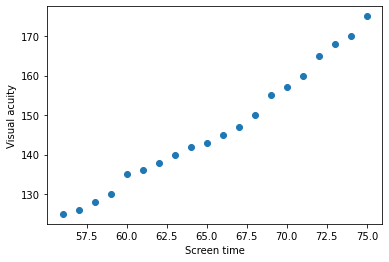

In [67]:
import matplotlib.pyplot as plt

x = [68, 72, 74, 63, 60, 66, 69, 71, 73, 75, 62, 61, 65, 70, 64, 67, 59, 58, 56, 57]
y = [150, 165, 170, 140, 135, 145, 155, 160, 168, 175, 138, 136, 143, 157, 142, 147, 130, 128, 125, 126]

plt.scatter(x, y)
plt.xlabel('Screen time')
plt.ylabel('Visual acuity')
plt.title('')
plt.show()

In [66]:
len(y)

96

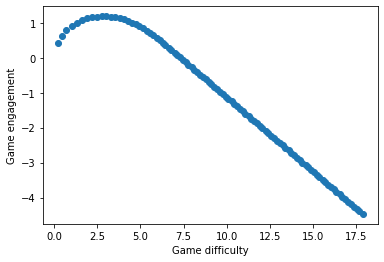

In [69]:
import matplotlib.pyplot as plt

x = [0.23, 0.47, 0.71, 1.05, 1.32, 1.63, 1.89, 2.21, 2.47, 2.77, 3.02, 3.31, 3.54, 3.82, 4.03, 4.29, 4.49, 4.74, 4.93, 5.17, 5.35, 5.58, 5.74, 5.96, 6.11, 6.31, 6.45, 6.65, 6.79, 6.98, 7.12, 7.31, 7.45, 7.64, 7.78, 7.97, 8.11, 8.30, 8.44, 8.63, 8.77, 8.96, 9.10, 9.29, 9.43, 9.62, 9.76, 9.95, 10.09, 10.28, 10.42, 10.61, 10.75, 10.94, 11.08, 11.27, 11.41, 11.60, 11.74, 11.93, 12.07, 12.26, 12.40, 12.59, 12.73, 12.92, 13.06, 13.25, 13.39, 13.58, 13.72, 13.91, 14.05, 14.24, 14.38, 14.57, 14.71, 14.90, 15.04, 15.23, 15.37, 15.56, 15.70, 15.89, 16.03, 16.22, 16.36, 16.55, 16.69, 16.88, 17.02, 17.21, 17.35, 17.54, 17.68, 17.87,]

y = [0.41, 0.62, 0.79, 0.91, 1.01, 1.08, 1.13, 1.16, 1.18, 1.19, 1.19, 1.18, 1.16, 1.13, 1.10, 1.06, 1.01, 0.96, 0.90, 0.84, 0.78, 0.71, 0.64, 0.57, 0.50, 0.43, 0.36, 0.29, 0.22, 0.15, 0.08, 0.01, -0.06, -0.13, -0.20, -0.27, -0.34, -0.41, -0.48, -0.55, -0.62, -0.69, -0.76, -0.83, -0.90, -0.97, -1.04, -1.11, -1.18, -1.25, -1.32, -1.39, -1.46, -1.53, -1.60, -1.67, -1.74, -1.81, -1.88, -1.95, -2.02, -2.09, -2.16, -2.23, -2.30, -2.37, -2.44, -2.51, -2.58, -2.65, -2.72, -2.79, -2.86, -2.93, -3.00, -3.07, -3.14, -3.21, -3.28, -3.35, -3.42, -3.49, -3.56, -3.63, -3.70, -3.77, -3.84, -3.91, -3.98, -4.05, -4.12, -4.19, -4.26, -4.33, -4.40, -4.47] 
plt.scatter(x, y)
plt.xlabel('Game difficulty')
plt.ylabel('Game engagement')
plt.show()

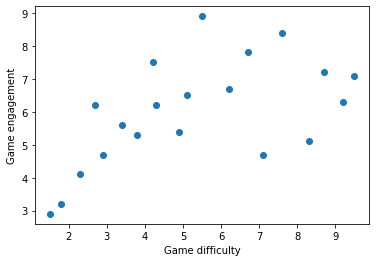

In [8]:
import matplotlib.pyplot as plt

x = [4.2, 8.3, 2.7, 5.5, 7.1, 3.4, 9.2, 1.8, 6.7, 5.1, 4.9, 8.7, 2.3, 7.6, 3.8, 1.5, 6.2, 9.5, 4.3, 2.9]
y = [7.5, 5.1, 6.2, 8.9, 4.7, 5.6, 6.3, 3.2, 7.8, 6.5, 5.4, 7.2, 4.1, 8.4, 5.3, 2.9, 6.7, 7.1, 6.2, 4.7]


plt.scatter(x, y)
plt.xlabel('Game difficulty')
plt.ylabel('Game engagement')
plt.show()

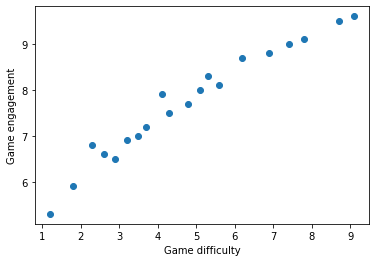

In [13]:
import matplotlib.pyplot as plt

x = [2.3, 4.1, 3.7, 5.6, 6.2, 1.8, 7.4, 2.9, 5.3, 3.5, 4.8, 8.7, 1.2, 6.9, 9.1, 7.8, 3.2, 2.6, 4.3, 5.1]
y = [6.8, 7.9, 7.2, 8.1, 8.7, 5.9, 9.0, 6.5, 8.3, 7.0, 7.7, 9.5, 5.3, 8.8, 9.6, 9.1, 6.9, 6.6, 7.5, 8.0]

plt.scatter(x, y)
plt.xlabel('Game difficulty')
plt.ylabel('Game engagement')
plt.show()

In [62]:
def generate_data_decisionmaking_problems(model, version, num_data=20, features=None, target=None):

    instructions = {}
    instructions['claude'] = {}
    num_dim = len(features)
    
    def featurenames_to_text(features, num_dim):
        if num_dim==1:
            return f'feature in this case is {features[0].lower()}', 'The feature takes', '- feature value, target value'
        elif num_dim==2:
            return f'features in this case are {features[0].lower()} and {features[1].lower()}', 'These features take', '- feature value 1, feature value 2, target value'
        
    feature_text, style, template = featurenames_to_text(features, num_dim)
    
    generate_data_prompt_v0 = f" I am a psychologist who wants to run a decision-making experiment."\
                          " For a decision-making experiment, I need a list of features with their corresponding target."\
                         f" The {feature_text}."\
                         f" {style} on only numerical values and must be continuous."\
                         f" The target, {target.lower()}, should be predictable from the feature values and must also take on continuous values."\
                          " \n\n"\
                         f" Please generate a list of {str(num_data)} feature-target pairs"\
                          " sequentially using the following template for each row: \n"\
                         f" {template} \n"\
                         f"  Please do not skip any row; values taken by features and targets do not need to be ordered."
    
    instructions['claude']['v0'] = generate_data_prompt_v0
    
    return instructions[model][version]

In [63]:
features= ["Material Cost", "Production Time"]
target = "Product Price"

In [64]:
print(generate_data_decisionmaking_problems(model='claude', version='v0', features=features, target=target))

 I am a psychologist who wants to run a decision-making experiment. For a decision-making experiment, I need a list of features with their corresponding target. The features in this case are material cost and production time. These features take on only numerical values and must be continuous. The target, product price, should be predictable from the feature values and must also take on continuous values. 

 Please generate a list of 20 feature-target pairs sequentially using the following template for each row: 
 - feature value 1, feature value 2, target value 
  Please do not skip any row; values taken by features and targets do not need to be ordered.


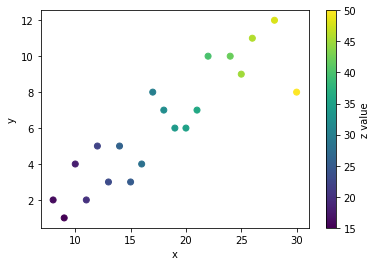

In [28]:
x = [15, 12, 8, 20, 10, 30, 18, 22, 25, 14, 16, 21, 19, 17, 13, 11, 9, 24, 28, 26]
y = [3, 5, 2, 6, 4, 8, 7, 10, 9, 5, 4, 7, 6, 8, 3, 2, 1, 10, 12, 11]
z = [25, 22, 16, 35, 18, 50, 32, 40, 45, 26, 28, 36, 34, 30, 23, 20, 15, 42, 48, 46]

plt.scatter(x, y, c=z)
plt.colorbar(label='z value')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

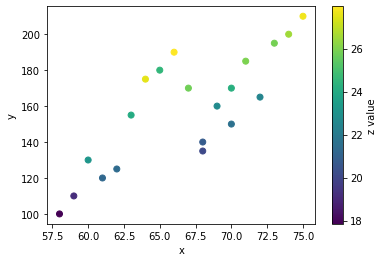

In [25]:
x = np.array([65, 72, 68, 60, 75, 62, 70, 64, 66, 63, 61, 59, 71, 67, 69, 74, 68, 58, 73, 70])
y = np.array([180, 165, 140, 130, 210, 125, 150, 175, 190, 155, 120, 110, 185, 170, 160, 200, 135, 100, 195, 170])
z = np.array([24.49, 22.46, 20.76, 23.17, 27.76, 21.34, 21.60, 27.56, 27.96, 24.02, 21.21, 19.15, 25.95, 25.77, 22.68, 26.53, 20.09, 17.85, 25.86, 24.22])

plt.scatter(x, y, c=z)
plt.colorbar(label='z value')
plt.xlabel('x')
plt.ylabel('y')
plt.show()